[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Daddy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Daddy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


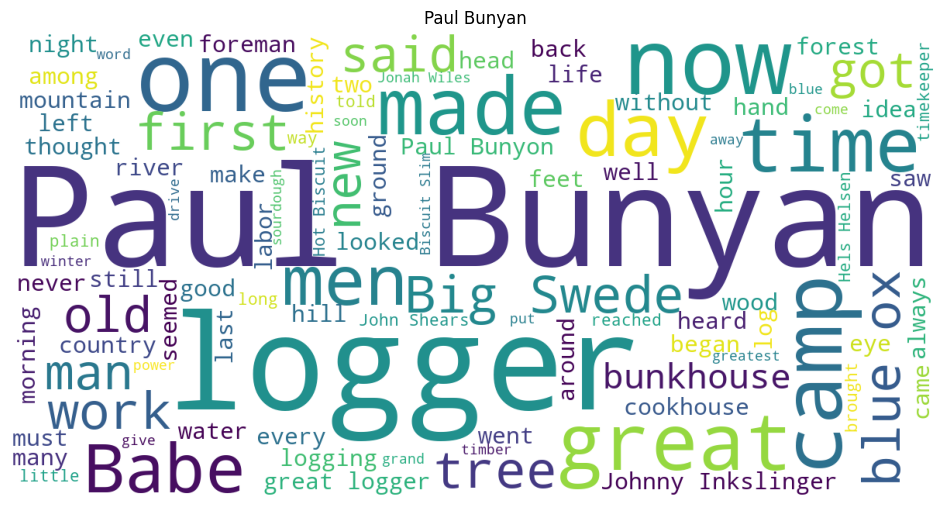

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import random
import re
import seaborn as sns
import nltk
import ipywidgets as widgets

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from scipy.optimize import curve_fit
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
from IPython.display import display, clear_output

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# Get the text of 'Paul Bunyan' by James Stevens from Project Gutenberg
r = requests.get('https://www.gutenberg.org/cache/epub/70060/pg70060.txt')
r.encoding = 'utf-8'
booktext = r.text

# Function to clean the text
def clean_text(text):
    # Remove Project Gutenberg header
    start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK PAUL BUNYAN ***"
    end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK PAUL BUNYAN ***"
    start_index = text.find(start_marker) + len(start_marker)
    if start_index == -1:
        start_index = 0
    else:
        start_index = text.index("\n", start_index) + 1
    end_index = text.find(end_marker)
    if end_index == -1:
        end_index = len(text)
    text = text[start_index:end_index]

    # Remove the mentions of illustrations
    text = re.sub(r'\[Illustration\]', '', text)
    # Remove punctuation but keep capitaliation for name recognition
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# Clean the text
cleaned_text = clean_text(booktext)

# Split into words
words = cleaned_text.split()

# Tokenize the text
tokens = word_tokenize(cleaned_text)

# Perform part-of-speech tagging
tagged_tokens = pos_tag(tokens)

# Remove stopwords
stopwords = set(STOPWORDS)
additional_stopwords = ['said','now','one']
stopwords.update(additional_stopwords)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=88, 
        scale=3,
        random_state=random.randint(0,1000)
    ).generate(str(data))

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    if title:
        plt.title(title)
    plt.show()

show_wordcloud(cleaned_text, 'Paul Bunyan')

In [ ]:
# Word frequency analysis
words = [word.lower() for word in tokens if word.lower() not in stopwords]

# Count word frequencies
word_freq = Counter(words)

# Convert to DataFrame
df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])
df = df.sort_values('frequency', ascending=False)
df['word'] = df.index
df = df.reset_index(drop=True)

# Calculate additional statistics
total_words = len(words)
df['length'] = df['word'].str.len()
df['frequency_percentage'] = df['frequency'] / total_words * 100
df['normalized_frequency_1000'] = df['frequency'] / total_words * 1000  # Normalized per 1000 words

# Print the table
print(df.head(20).to_string(index=False))

# Calculate and print some overall statistics
unique_words = len(df)
average_word_length = df['length'].mean()

# Calculate the Type-Token Ratio
ttr = unique_words / total_words

# Advanced Lexical Diversity Measures
def mtld(text, ttr_threshold=0.72):
    def mtld_calc(text, ttr_threshold):
        factors = 0
        types = set()
        tokens = 0
        for word in text:
            types.add(word)
            tokens += 1
            ttr = len(types) / tokens
            if ttr <= ttr_threshold:
                factors += 1
                types = set()
                tokens = 0
        if tokens > 0:
            factors += (1 - ttr) / (1 - ttr_threshold)
        return len(text) / factors if factors > 0 else 0
    
    forward = mtld_calc(text, ttr_threshold)
    backward = mtld_calc(text[::-1], ttr_threshold)
    return (forward + backward) / 2

def mattr(text, window_size=1000):
    ttrs = []
    for i in range(len(text) - window_size + 1):
        window = text[i:i+window_size]
        ttrs.append(len(set(window)) / len(window))
    return np.mean(ttrs)

def mass_function_residual(text, num_points=10):
    def expected_types(n, a, b):
        return a * n ** b

    def calculate_observed_types(text, num_points):
        observed_types = []
        step = len(text) // num_points
        for i in range(step, len(text) + 1, step):
            observed_types.append(len(set(text[:i])))
        return observed_types, step

    observed_types, step = calculate_observed_types(text, num_points)
    x = np.arange(step, len(text) + 1, step)
    
    # Fit the expected function to the observed data
    popt, _ = curve_fit(expected_types, x, observed_types)
    
    # Calculate the residuals
    expected = expected_types(x, *popt)
    residuals = np.array(observed_types) - expected
    
    # Normalize the residuals
    normalized_residuals = residuals / expected
    
    # Return the mean of the absolute normalized residuals
    return np.mean(np.abs(normalized_residuals))

# Calculate advanced measures
mtld_score = mtld(words)
mattr_score = mattr(words)
mfr_score = mass_function_residual(words)

# Print Statistics
print(f"\nTotal words (tokens): {total_words}")
print(f"Unique words (types): {unique_words}")
print(f"Type-Token Ratio: {ttr:.4f}")
print(f"MATTR: {mattr_score:.4f}")
print(f"MTLD: {mtld_score:.4f}")
print(f"Mass-Function Residual: {mfr_score:.4f}")
print(f"Average word length: {df['length'].mean():.2f}")

In [ ]:
# Visualization functions
def plot_top_words(df, n=20, normalized=False):
    plt.figure(figsize=(12, 8))
    if normalized:
        sns.barplot(x='normalized_frequency_1000', y='word', data=df.head(n))
        plt.title(f'Top {n} Most Frequent Words (Normalized per 1000 words)')
        plt.xlabel('Normalized Frequency')
    else:
        sns.barplot(x='frequency', y='word', data=df.head(n))
        plt.title(f'Top {n} Most Frequent Words')
        plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

def plot_word_length_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['length'], bins=20, kde=False)
    plt.title('Distribution of Word Lengths')
    plt.xlabel('Word Length')
    plt.ylabel('Count')
    plt.show()

def plot_frequency_vs_length(df):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='length', y='frequency', data=df)
    plt.title('Word Frequency vs Word Length')
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.show()

def plot_cumulative_frequency(df):
    df_sorted = df.sort_values('frequency', ascending=False)
    df_sorted['cumulative_freq'] = df_sorted['frequency'].cumsum() / df_sorted['frequency'].sum() * 100
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(df_sorted) + 1), df_sorted['cumulative_freq'])
    plt.title('Cumulative Word Frequency')
    plt.xlabel('Number of Unique Words')
    plt.ylabel('Cumulative Frequency (%)')
    plt.ylim(0, 100)
    plt.show()

# Create visualizations
plot_top_words(df,normalized=False)
plot_top_words(df,normalized=True)
plot_word_length_distribution(df)
plot_frequency_vs_length(df)
plot_cumulative_frequency(df)


In [ ]:
# Function to identify potential character names
def is_potential_name(word, tag):
    return (tag.startswith('NNP') and len(word) > 1 and word[0].isupper()) or word in ['I', 'Me', 'You', 'He', 'She', 'Him', 'Her']

# Extract potential character names
potential_names = [word for word, tag in tagged_tokens if is_potential_name(word, tag)]

# Function to combine first and last names
def combine_names(names):
    combined_names = []
    i = 0
    while i < len(names) - 1:
        if names[i][0].isupper() and names[i+1][0].isupper():
            combined_names.append(f"{names[i]} {names[i+1]}")
            i += 2
        else:
            combined_names.append(names[i])
            i += 1
    if i == len(names) - 1:
        combined_names.append(names[i])
    return combined_names

# Combine names
combined_names = combine_names(potential_names)

# Count name occurrences
name_counts = Counter(combined_names)

# Function to normalize names
def normalize_name(name):
    # Remove possessive 's
    name = re.sub(r"'s\b", "", name)
    # Split the name into parts
    parts = name.split()
    # Sort the parts to handle cases like "Bunyan Paul"
    parts.sort()
    # Join the parts back together
    return " ".join(parts)

# Function to combine similar names
def combine_similar_names(name_counts):
    normalized_counts = {}
    for name, count in name_counts.items():
        normalized_name = normalize_name(name)
        if normalized_name in normalized_counts:
            normalized_counts[normalized_name] += count
        else:
            normalized_counts[normalized_name] = count
    return normalized_counts

# Combine Similar Names
name_counts = combine_similar_names(name_counts)

# Remove nonsensical combinations
name_counts = {name: count for name, count in name_counts.items() 
               if not (name.split()[0] == name.split()[-1] and len(name.split()) > 1)}

# Convert to DataFrame
name_df = pd.DataFrame.from_dict(name_counts, orient='index', columns=['frequency'])
name_df = name_df.sort_values('frequency', ascending=False)
name_df['name'] = name_df.index
name_df = name_df.reset_index(drop=True)

# Calculate percentage of total names
total_names = name_df['frequency'].sum()
name_df['percentage'] = name_df['frequency'] / total_names * 100



# Print top character names
print("Top 20 Potential Character Names:")
print(name_df[['name', 'frequency', 'percentage']].head(20).to_string(index=False))

# Visualization for character names
def plot_top_names(df, n=20):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='frequency', y='name', data=df.head(n))
    plt.title(f'Top {n} Most Frequent Character Names')
    plt.xlabel('Frequency')
    plt.ylabel('Name')
    plt.show()

plot_top_names(name_df)

Top 20 Potential Character Names with Sentiment:
             name  frequency  percentage  sentiment_compound
      Bunyan Paul        242   10.637363                 0.0
     Bunyans Paul         66    2.901099                 0.0
        Big Swede         54    2.373626                 1.0
        Bunyan He         45    1.978022                 1.0
Inkslinger Johnny         41    1.802198                 0.0
      Bunyon Paul         34    1.494505                 0.0
          He Paul         32    1.406593                 1.0
         Bunyan I         23    1.010989                 1.0
      Hels Helsen         23    1.010989                 1.0
     Biscuit Slim         20    0.879121                 1.0
      Jonah Wiles         19    0.835165                 1.0
      John Shears         18    0.791209                 1.0
    Sam Sourdough         16    0.703297                 0.0
       Paul Swede         16    0.703297                 0.0
    Bunyan Johnny         16    0.70

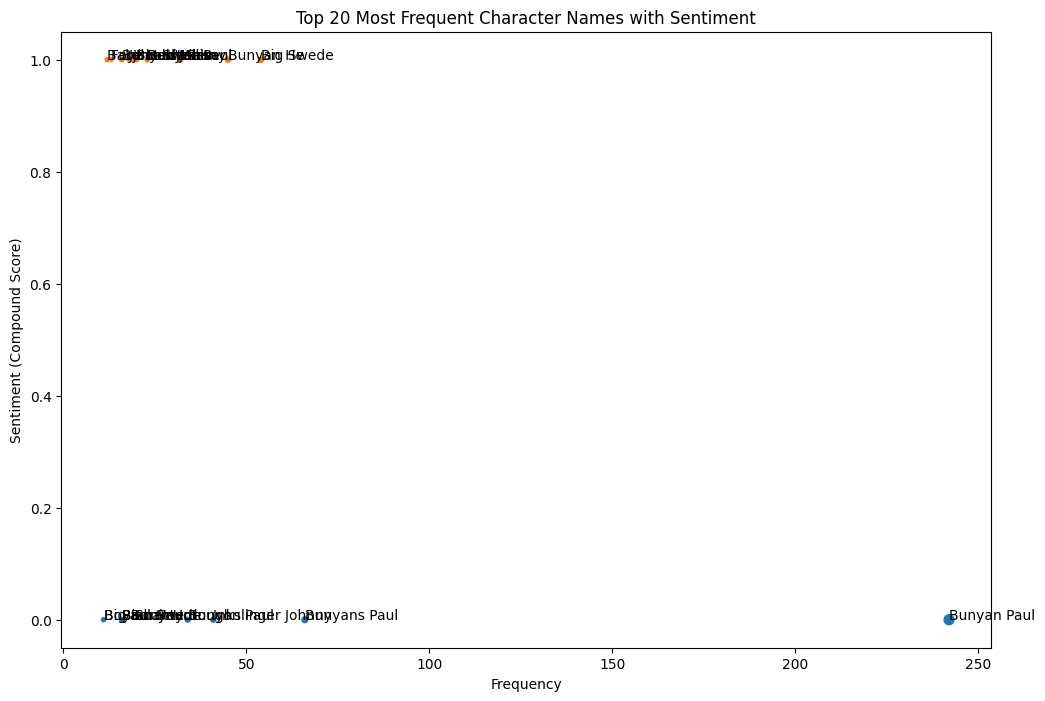

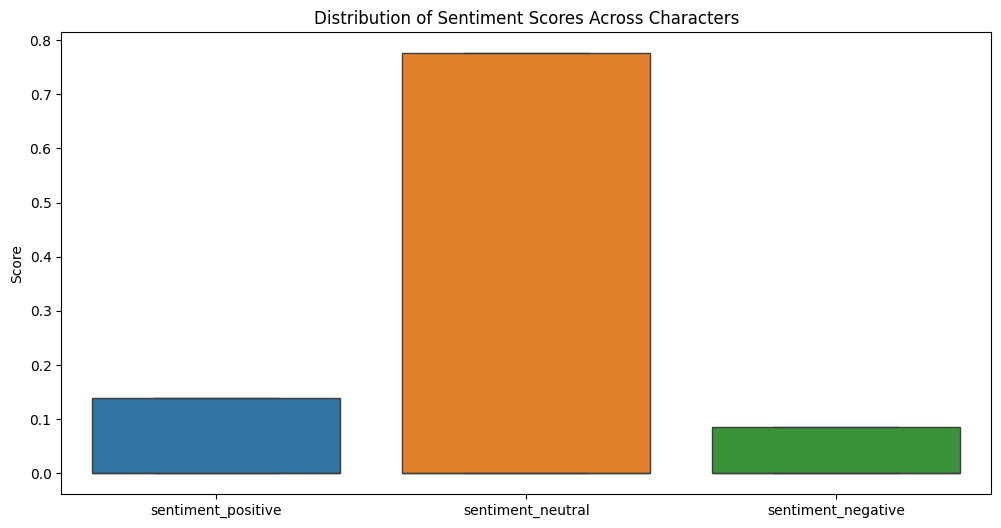

In [61]:
# Sentiment analysis
def get_character_sentiment(character, text):
    sia = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(text)
    character_sentences = [sent for sent in sentences if character.lower() in sent.lower()]
    if not character_sentences:
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    sentiments = [sia.polarity_scores(sent) for sent in character_sentences]
    avg_sentiment = {key: sum(sent[key] for sent in sentiments) / len(sentiments) 
                     for key in sentiments[0]}
    return avg_sentiment

# Get the top 20 characters
top_20_characters = name_df.head(20)

# Add sentiment analysis to the DataFrame
for index, row in top_20_characters.iterrows():
    sentiment = get_character_sentiment(row['name'], cleaned_text)
    name_df.at[index, 'sentiment_compound'] = sentiment['compound']
    name_df.at[index, 'sentiment_positive'] = sentiment['pos']
    name_df.at[index, 'sentiment_neutral'] = sentiment['neu']
    name_df.at[index, 'sentiment_negative'] = sentiment['neg']

# Print top character names with sentiment
print("Top 20 Potential Character Names with Sentiment:")
print(name_df[['name', 'frequency', 'percentage', 'sentiment_compound']].head(20).to_string(index=False))

# Visualization for character names and sentiment
def plot_top_names_sentiment(df, n=20):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='frequency', y='sentiment_compound', size='frequency', 
                    hue='sentiment_compound', data=df.head(n), legend=False)
    plt.title(f'Top {n} Most Frequent Character Names with Sentiment')
    plt.xlabel('Frequency')
    plt.ylabel('Sentiment (Compound Score)')
    
    for i, row in df.head(n).iterrows():
        plt.annotate(row['name'], (row['frequency'], row['sentiment_compound']))
    
    plt.show()

plot_top_names_sentiment(name_df)

# Additional visualization: Sentiment distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=name_df[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']])
plt.title('Distribution of Sentiment Scores Across Characters')
plt.ylabel('Score')
plt.show()

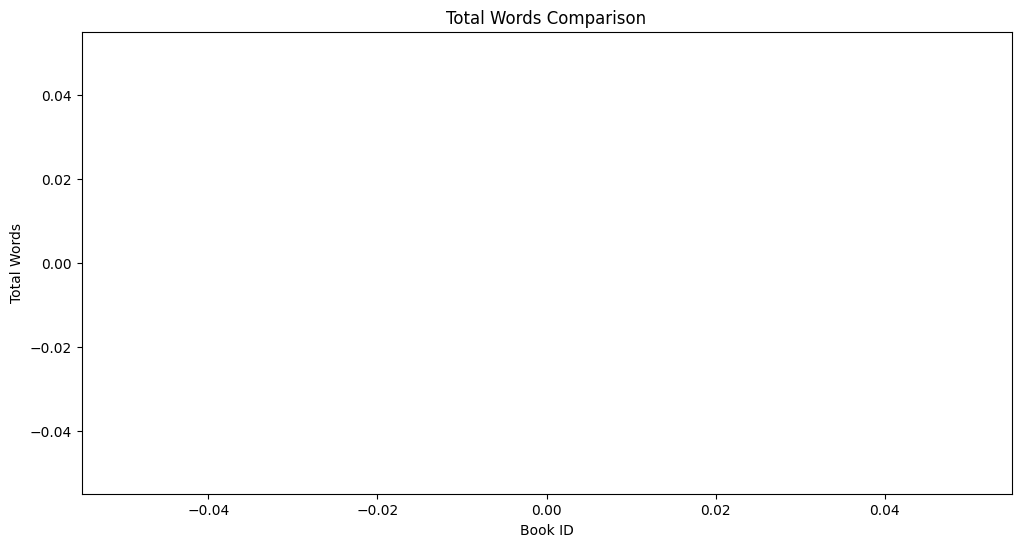

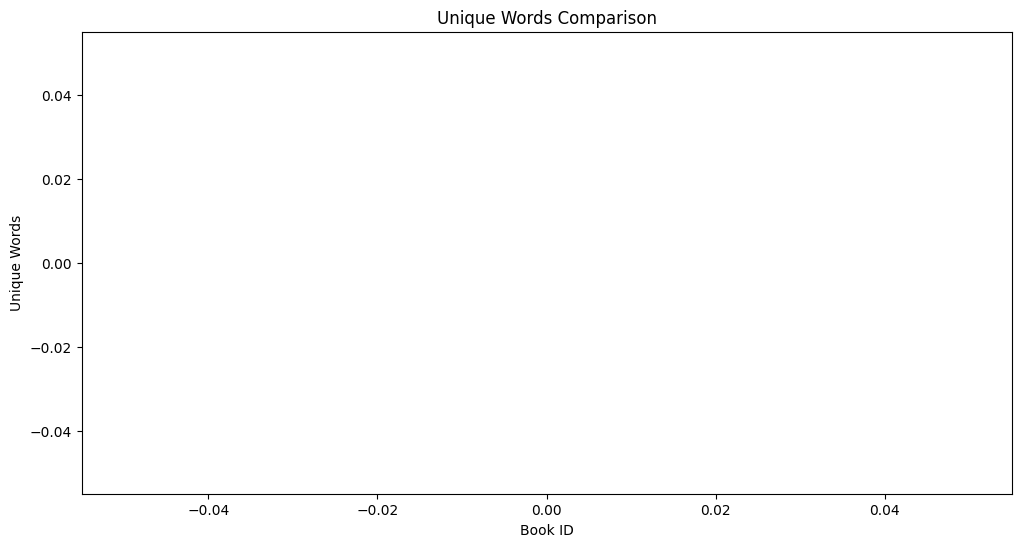

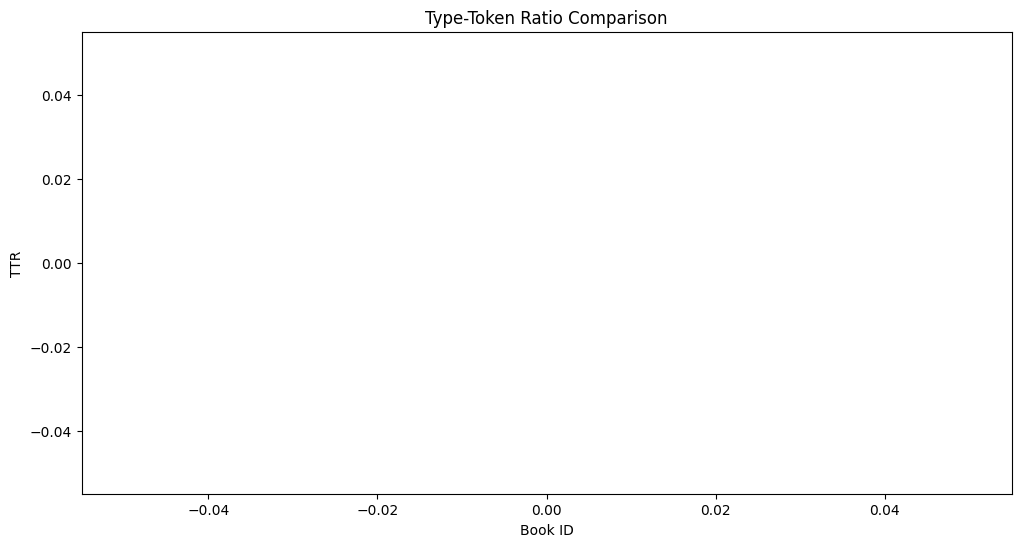

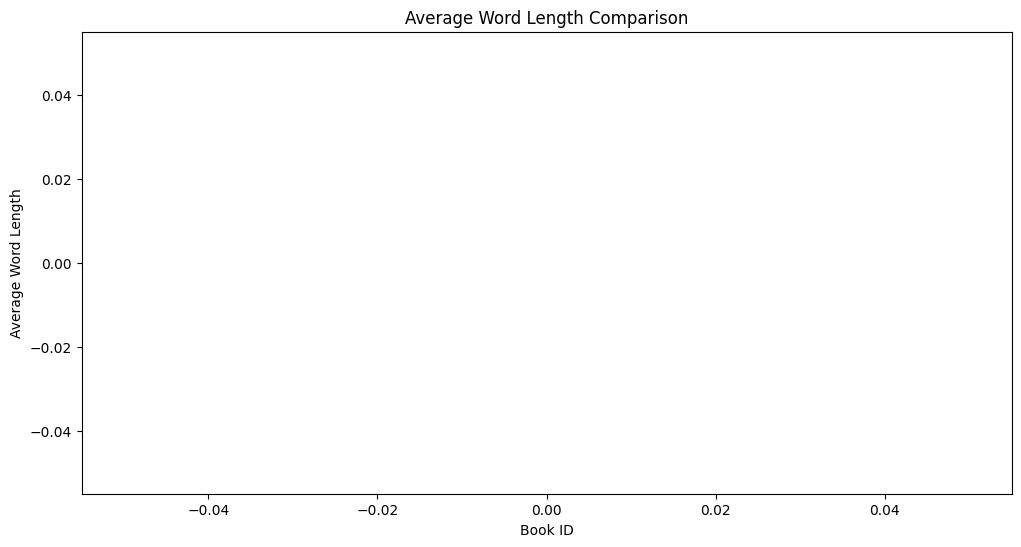

<Figure size 1500x1000 with 0 Axes>

In [65]:
def fetch_gutenberg_book(url):
    r = requests.get(url)
    r.encoding = 'utf-8'
    return r.text

def get_gutenberg_catalog(num_books=100):
    url = f"https://www.gutenberg.org/browse/scores/top#{num_books}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    books = []
    for li in soup.find_all('li'):
        a = li.find('a')
        if a and a.get('href', '').startswith('/ebooks/'):
            book_id = a['href'].split('/')[-1]
            title = a.text.strip()
            books.append((book_id, title))
    return books

def create_book_selection_ui(books):
    book_dict = {f"{book[1]} (ID: {book[0]})": book[0] for book in books}
    book_dropdown = widgets.Dropdown(
        options=book_dict.keys(),
        description='Select a book:',
        disabled=False,
    )
    add_button = widgets.Button(description="Add Book")
    selected_books = widgets.Textarea(
        value='',
        placeholder='Selected books will appear here',
        description='Selected:',
        disabled=True
    )
    
    book_selections = []
    
    def on_add_button_click(b):
        selected = book_dropdown.value
        book_id = book_dict[selected]
        if book_id not in book_selections:
            book_selections.append(book_id)
            selected_books.value = ", ".join([f"ID: {id}" for id in book_selections])
    
    add_button.on_click(on_add_button_click)
    
    display(widgets.VBox([book_dropdown, add_button, selected_books]))
    
    return book_selections

def analyze_books(book_ids):
    results = {}
    for book_id in book_ids:
        url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
        book_text = fetch_gutenberg_book(url)
        cleaned_text = clean_text(book_text)
        
        # Perform analysis (reuse functions from the original code)
        words = word_tokenize(cleaned_text.lower())
        word_freq = Counter(words)
        total_words = len(words)
        unique_words = len(set(words))
        ttr = unique_words / total_words
        avg_word_length = sum(len(word) for word in words) / total_words
        
        results[book_id] = {
            'total_words': total_words,
            'unique_words': unique_words,
            'ttr': ttr,
            'avg_word_length': avg_word_length,
            'top_words': word_freq.most_common(20)
        }
    
    return results

def compare_books(results):
    # Create comparison visualizations
    book_ids = list(results.keys())
    
    # Compare total words
    plt.figure(figsize=(12, 6))
    plt.bar(book_ids, [results[book_id]['total_words'] for book_id in book_ids])
    plt.title('Total Words Comparison')
    plt.xlabel('Book ID')
    plt.ylabel('Total Words')
    plt.show()
    
    # Compare unique words
    plt.figure(figsize=(12, 6))
    plt.bar(book_ids, [results[book_id]['unique_words'] for book_id in book_ids])
    plt.title('Unique Words Comparison')
    plt.xlabel('Book ID')
    plt.ylabel('Unique Words')
    plt.show()
    
    # Compare TTR
    plt.figure(figsize=(12, 6))
    plt.bar(book_ids, [results[book_id]['ttr'] for book_id in book_ids])
    plt.title('Type-Token Ratio Comparison')
    plt.xlabel('Book ID')
    plt.ylabel('TTR')
    plt.show()
    
    # Compare average word length
    plt.figure(figsize=(12, 6))
    plt.bar(book_ids, [results[book_id]['avg_word_length'] for book_id in book_ids])
    plt.title('Average Word Length Comparison')
    plt.xlabel('Book ID')
    plt.ylabel('Average Word Length')
    plt.show()
    
    # Compare top words
    plt.figure(figsize=(15, 10))
    for i, book_id in enumerate(book_ids):
        top_words = results[book_id]['top_words']
        plt.subplot(len(book_ids), 1, i+1)
        plt.barh([word for word, _ in top_words], [count for _, count in top_words])
        plt.title(f'Top 20 Words - Book ID: {book_id}')
        plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

# Main execution
books = get_gutenberg_catalog()
selected_book_ids = create_book_selection_ui(books)

# Wait for user to select books
input("Press Enter when you've finished selecting books...")

print(selected_book_ids)
results = analyze_books(selected_book_ids)
compare_books(results)